# Installing and importing packages


In [ ]:
!pip install -qU svgwrite ndjson torch

In [ ]:
import requests
import ndjson
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import json
import svgwrite
from IPython.display import SVG, display, clear_output
import math

# Setting pre-train parameters and user-controlled knobs

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset_url = 'https://storage.googleapis.com/quickdraw_dataset/full/simplified/triangle.ndjson'
max_doodle_len = 5
max_stroke_len = 1
max_gen_len = 1

batch_size = 50
lr = 0.001
num_epochs = 1000
d_model = 512
num_layers = 6
num_heads = 8
ff_dim = 2048
dropout = 0.1

# Util functions for data pre-processing

In [ ]:
def load_data():
    response = requests.get(dataset_url)
    data = ndjson.loads(response.text)
    return data

In [ ]:
def extract_useful_doodles(data):
    useful_doodles = []
    for doodle in data:
        if doodle['recognized']:
            useful_doodles.append(doodle['drawing'])
    return useful_doodles

In [ ]:
def zip_strokes(data):
    new_data = []
    for doodle in data:
        new_data.append([[list(x) for x in zip(stroke[0], stroke[1])] for stroke in doodle])
    return new_data

In [ ]:
def pad_all_doodles(data):
    global max_stroke_len
    for doodle in data:
        max_stroke_len = max(
            max_stroke_len,
            max([len(stroke) for stroke in doodle])
        )

    new_data = []
    for doodle in data:
        new_doodle = []
        for stroke in doodle:
            new_stroke = np.pad(
                stroke,
                ((max_stroke_len - len(stroke), 0), (0, 0)),
                mode='constant',
                constant_values=0
            )
            new_doodle.append(new_stroke)
        new_data.append(np.array(new_doodle))

    for index, doodle in enumerate(new_data):
        if max_doodle_len <= doodle.shape[0]:
            new_data[index] = doodle[doodle.shape[0] - max_doodle_len:]
        else:
            new_data[index] = np.pad(
                doodle,
                ((max_doodle_len - doodle.shape[0], 0), (max_stroke_len - doodle.shape[1], 0), (2 - doodle.shape[2], 0))
            )

    return np.array(new_data)

# Util functions for visualizations

In [ ]:
def draw_strokes_real_time(strokes):
    strokes = np.flip(strokes, axis=1)

    dwg = svgwrite.Drawing(size=(255, 255))
    dwg.add(dwg.rect(insert=(0, 0), size=('100%', '100%'), fill='white'))
    display(SVG(dwg.tostring()))

    for stroke in strokes:
        polyline = dwg.polyline([(int(stroke[0][0]), int(stroke[0][1]))], stroke="black", fill="none", stroke_width=2)
        dwg.add(polyline)

        points = [(int(stroke[i][0]), int(stroke[i][1])) for i in range(1, len(stroke))]
        for point in points:
            if point == (0, 0): continue
            #print(point)
            polyline.points.append(point)
            display(SVG(dwg.tostring()))
            time.sleep(0.03)
            clear_output(wait=True)

# Import, process and test our dataset

In [ ]:
dataset = load_data()

In [ ]:
doodles = extract_useful_doodles(dataset)

In [ ]:
doodles = zip_strokes(doodles)

# Sanity check
assert np.allclose(
    np.array([list(x) for x in zip(dataset[0]['drawing'][0][0], dataset[0]['drawing'][0][1])]),
    doodles[0][0]
)

In [ ]:
doodles = pad_all_doodles(doodles)

# Sanity check
assert type(doodles[0]) == type(np.array([[]]))
assert all([doodle.shape[2] == 2 for doodle in doodles])

In [ ]:
display(doodles.shape)

(120500, 5, 106, 2)

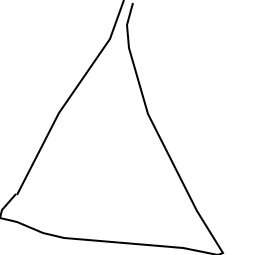

In [ ]:
for i in np.random.randint(0, len(doodles), size=10):
    draw_strokes_real_time(doodles[i])
    time.sleep(0.5)

# Train test val split

In [ ]:
class DoodleDataset(Dataset):
    def __init__(self, doodles):
        self.doodles = doodles

    def __len__(self):
        return len(self.doodles)

    def __getitem__(self, idx):
        # Get a single doodle from the array
        doodle = self.doodles[idx]
        return doodle

In [ ]:
def collate_fn(batch):
    src = [torch.tensor(doodle[:-1]) for doodle in batch]
    tgt = [torch.tensor(doodle[-1]) for doodle in batch]

    return torch.stack(src), torch.stack(tgt)

In [ ]:
from sklearn.model_selection import train_test_split

doodles = torch.tensor(doodles)
train_data, test_data = train_test_split(doodles, test_size=0.3, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print("train data:", len(train_data))
print("val data:", len(val_data))
print("test data:", len(test_data))

<ipython-input-67-387fdd8c28f8>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  doodles = torch.tensor(doodles)


train data: 67500
val data: 16876
test data: 36162


In [ ]:
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Define the transformer-based encoder

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        batch_size, seq_len = x.size(0), x.size(2)
        pe = self.pe[:seq_len, :]
        x = pe
        return self.dropout(x)

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout):
        super(EncoderLayer, self).__init__()

        self.self_attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src: [seq_len, batch_size, d_model]
        src2, _ = self.self_attention(src, src, src)
        src = src + self.dropout(self.layer_norm1(src2))
        src2 = self.feedforward(src)
        src = src + self.dropout(self.layer_norm2(src2))
        return src

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, num_layers, num_heads, ff_dim, dropout):
        super(Encoder, self).__init__()

        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, ff_dim, dropout) for _ in range(num_layers)])

    def forward(self, src):
        src = torch.tensor(src).float()
        src = self.embedding(src)
        src = self.positional_encoding(src)

        for layer in self.layers:
            src = layer(src)

        return src

# Define the transformer-based decoder

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout):
        super(DecoderLayer, self).__init__()

        self.self_attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.encoder_attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.layer_norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, memory):
        tgt2, _ = self.self_attention(tgt, tgt, tgt)
        tgt = tgt + self.dropout(self.layer_norm1(tgt2))

        tgt2, _ = self.encoder_attention(tgt, memory, memory)
        tgt = tgt + self.dropout(self.layer_norm2(tgt2))

        tgt2 = self.feedforward(tgt)
        tgt = tgt + self.dropout(self.layer_norm3(tgt2))

        return tgt

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, d_model, num_layers, num_heads, ff_dim, dropout):
        super(Decoder, self).__init__()

        self.embedding = nn.Linear(output_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, ff_dim, dropout) for _ in range(num_layers)])
        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, tgt, memory):
        tgt = torch.tensor(tgt).float()
        tgt = self.embedding(tgt)
        tgt = self.positional_encoding(tgt)

        for layer in self.layers:
            tgt = layer(tgt, memory)

        return self.fc_out(tgt)

# Define the training function

In [ ]:
def train_model(encoder, decoder, criterion, optimizer, train_loader, num_epochs):
    encoder.train()
    decoder.train()

    for epoch in range(num_epochs):
        total_loss = 0.0

        for src, tgt in train_loader:
            src = src.float().to(device)
            tgt = tgt.float().to(device)

            optimizer.zero_grad()
            memory = encoder(src)
            output = decoder(tgt, memory)

            loss = criterion(output.view(-1, output.size(-1)), tgt.view(-1, tgt.size(-1)))
            loss.backward()
            optimizer.step()

            # Reshape output and target tensors to have the same number of elements
            output = output.view(-1, output.size(-1))  # Flatten output
            tgt = tgt.view(-1, tgt.size(-1))            # Flatten target

            # Ensure that the output and target tensors have the same number of elements
            if output.size(0) != tgt.size(0):
                min_size = min(output.size(0), tgt.size(0))
                output = output[:min_size]
                tgt = tgt[:min_size]

            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        epoch_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    torch.save(encoder.state_dict(), 'encoder_model.pth')
    torch.save(decoder.state_dict(), 'decoder_model.pth')

# Train the model

In [ ]:
#input_dim = sketches
input_dim = 2
output_dim = 2

encoder = Encoder(input_dim, d_model, num_layers, num_heads, ff_dim, dropout)
decoder = Decoder(output_dim, d_model, num_layers, num_heads, ff_dim, dropout)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

train_model(encoder, decoder, criterion, optimizer, trainloader, num_epochs)

()


<ipython-input-56-3fcab87428f8>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src = [torch.tensor(doodle[:-1]) for doodle in batch]
<ipython-input-56-3fcab87428f8>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tgt = [torch.tensor(doodle[-1]) for doodle in batch]


1350 cnt
()
1350 cnt
()
1350 cnt
()
1350 cnt
()
1350 cnt
()
1350 cnt
()
1350 cnt
()
1350 cnt
()
1350 cnt
()
1350 cnt
()


KeyboardInterrupt: 

# Set the models to eval, and run tests

In [ ]:
encoder = torch.load('encoder_model.pth')
decoder = torch.load('decoder_model.pth')

encoder.eval()
decoder.eval()

with torch.no_grad():
    for i in np.random.randint(0, len(test_sketches), size=10):
        input_seq = test_sketches[i]

        encoded_seq = encoder(input_seq)
        output_seq = decoder(encoded_seq)

        print(f"Image {i+1} - Input Strokes:")
        draw_strokes_real_time(input_seq)
        print(f"Image {i+1} - Output Strokes:")
        draw_strokes_real_time(output_seq)